# 비트코인 어떤걸사고 언제팔까

## 개요
**전략** : 120분 중 가격이 최대인 위치(argmax)와 그때의 가격(max) 예측, 이때 X는 open, volume, trades 3개의 변수를 이용했고, 1380분의 데이터를 10개씩 잘라 평균값을 사용했다. X는 138x3=414개의 column을 가지고있다.<br>
**과정**<br>
1. Train, Validation, Test data 분리
2. Train data로 LGBM을 이용해 argmax, max를 예측하는 모델 생성(이때 모델의 파라미터는 Validation data의 mse를 최소화하는 방향으로
3. Test data를 이용해 투자수익 계산(max를 1.015초과로 예측한 sample_id에서 argmax의 위치에 판매하는 전략<br>
**개선방향**<br>
- 코인 구매 비중을 1이아니라 max를 예상한 값의 비율로 설정
- 1380분의 데이터를 10등분해서 평균을 사용했는데, 그냥 최근 n일 데이터를 사용할 수 있음. 이러면 학습데이터양도 증가


In [ ]:
# 구글 드라이브와 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 기본 라이브러리
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

In [ ]:

# 모델링 관련
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

import lightgbm as lgb

In [ ]:
# plotting 관련
import cufflinks as cf
import plotly.offline
cf.go_offline()
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
os.chdir('./drive/MyDrive/projects/coin')  # 현재 폴더 위치 변경

In [ ]:
# # 일부 데이터만 불러오기
# nrow = 500
# train_x = pd.read_csv('./open/train_x_df.csv', nrows=1380 * nrow)
# train_y = pd.read_csv('./open/train_y_df.csv', nrows=120 * nrow)
train_x = pd.read_csv('./open/train_x_df.csv')
train_y = pd.read_csv('./open/train_y_df.csv')

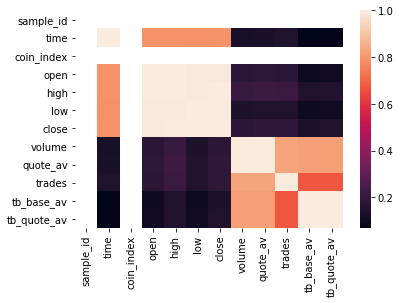

In [ ]:
sns.heatmap(train_x[train_x['sample_id'] == 0].corr())

OHLC끼리 연관이 있고, Volume끼리도 연관이 있음 -> open, volume trades 3개 변수만 사용하자

In [ ]:
def mm(arr):
  """
  min max scaling
  """
  return (arr - min(arr))/ (max(arr) - min(arr))


def flatten(df):
  """
  1380 x 3을 flatten 하는 과정
  """
  df_flattened = np.array(df.loc[:,['open', 'volume', 'trades']]).reshape(len(df)//1380, 1380, 3)
  for i in range(len(df_flattened)):
      for j in range(3):
          df_flattened[i][:,j] = mm(df_flattened[i][:,j])
  df_flattened = df_flattened.reshape(len(df) // 1380, 1380, 3)
  return df_flattened


def grouping(arr, n):
  """
  10개씩 끊어 평균을 저장하는 과정
  """
  result = []
  cnt = len(arr) // n
  for i in range(cnt):
    result.append(np.mean(arr[10*i:10*(i+1)]))
  return result

In [ ]:
def preprocess_x(df):
  df_flattened = flatten(df)
  X = []
  for i in tqdm(range(len(df_flattened))):
    temp = []
    for j in range(3):
      temp.extend(grouping(df_flattened[i].T[j], 10))
    X.append(temp)
  X = pd.DataFrame(X)
  return X

In [ ]:
df_flattened = flatten(train_x)

In [ ]:
df_flattened[0].shape

(1380, 3)

In [ ]:
def preprocess_x(df):
  df_flattened = flatten(df)
  X = []
  for i in tqdm(range(len(df_flattened))):
    temp = []
    for j in range(3):
      temp.extend(grouping(df_flattened[i].T[j], 10))
    X.append(temp)
  X = pd.DataFrame(X)
  return X

In [ ]:
def preprocess_y(df):
  y_max = {'max':[], 'argmax': []}

  for i in tqdm(range(df['sample_id'].unique().max()+1)):
      y_max['max'].append(df[df['sample_id'] == i]['open'].max())
      y_max['argmax'].append(df[df['sample_id'] == i]['open'].argmax())
  y_max['max'] = np.array(y_max['max'])
  y_max['argmax'] = np.array(y_max['argmax'])
  return y_max

In [ ]:
def preprocess_y_120(df):
  y_max = {'max':[]}

  for i in tqdm(range(df['sample_id'].unique().max()+1)):
      y_max['max'].append(df[df['sample_id'] == i]['open'].iloc[-1])
      
  y_max['max'] = np.array(y_max['max'])
  return y_max

In [ ]:
X = preprocess_x(train_x)

100%|██████████| 7661/7661 [00:22<00:00, 343.34it/s]


In [ ]:
y = preprocess_y(train_y)

100%|██████████| 7661/7661 [00:24<00:00, 318.01it/s]


In [ ]:
y = preprocess_y_120(train_y)
y_max = y['max']

100%|██████████| 7661/7661 [00:11<00:00, 658.32it/s]


In [ ]:
y_argmax = y['argmax']
y_max = y['max']

In [ ]:
X_train, X_test, y_train, y_test, y_train_max, y_test_max = train_test_split(X, y_argmax, y_max, test_size=0.2, random_state=2021)

In [ ]:
X_train, X_valid, y_train, y_valid, y_train_max, y_valid_max = train_test_split(X_train, y_train, y_train_max, test_size=0.2, random_state=2021)

In [ ]:
list(range(train_x['sample_id'].unique().max()+1))[-1]

7660

In [ ]:
train_test_split(list(range(train_x['sample_id'].unique().max())), test_size=0.2, random_state=2021)

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413
0,0.239730,0.225031,0.125347,0.035752,0.071459,0.067688,0.099837,0.130566,0.139472,0.213915,0.250883,0.398068,0.455644,0.424636,0.392413,0.384385,0.353093,0.389025,0.413733,0.365487,0.378171,0.452877,0.455731,0.426197,0.391734,0.293220,0.152323,0.136110,0.200199,0.192708,0.214332,0.217187,0.271945,0.321369,0.360971,0.407298,0.388480,0.308077,0.376986,0.309196,...,0.136643,0.092160,0.072300,0.045238,0.056214,0.057433,0.036760,0.058595,0.067944,0.049303,0.092567,0.057317,0.175377,0.067305,0.071661,0.049826,0.043089,0.049129,0.068641,0.061382,0.049884,0.049187,0.067422,0.049071,0.076829,0.052729,0.061789,0.056736,0.081069,0.103310,0.069048,0.127003,0.066434,0.043554,0.041173,0.037631,0.077236,0.107549,0.118177,0.061150
1,0.593410,0.588357,0.525133,0.473393,0.391795,0.451865,0.450392,0.496275,0.498808,0.606203,0.677353,0.726367,0.702831,0.650431,0.684377,0.705657,0.711526,0.693271,0.662516,0.645249,0.675481,0.704665,0.659447,0.633603,0.633994,0.537336,0.500371,0.587181,0.668977,0.702411,0.713336,0.679871,0.665156,0.773333,0.810577,0.731438,0.764097,0.729367,0.741679,0.745503,...,0.038883,0.043693,0.068733,0.172421,0.086745,0.117798,0.127205,0.076964,0.067905,0.045778,0.048183,0.037199,0.052619,0.026884,0.027953,0.057242,0.049198,0.049278,0.048049,0.022154,0.022314,0.025307,0.025949,0.039017,0.052218,0.030679,0.033699,0.023864,0.026082,0.026109,0.033592,0.020043,0.057055,0.047648,0.026029,0.076964,0.051871,0.029316,0.043693,0.018546
2,0.829328,0.837790,0.828075,0.821092,0.781557,0.759458,0.817478,0.925077,0.947505,0.956870,0.949928,0.963052,0.984349,0.980160,0.944321,0.930643,0.921524,0.926576,0.901376,0.898398,0.912282,0.912487,0.910310,0.920949,0.931074,0.946272,0.945492,0.954179,0.959417,0.941404,0.927069,0.932737,0.954857,0.945143,0.957938,0.948223,0.936989,0.908975,0.910885,0.882542,...,0.031670,0.037093,0.021258,0.029718,0.039046,0.017137,0.044035,0.046204,0.043601,0.063557,0.027766,0.049241,0.042733,0.068113,0.066594,0.085900,0.158134,0.205423,0.140564,0.451627,0.431670,0.197397,0.312581,0.207592,0.141866,0.123427,0.233839,0.372017,0.287636,0.105640,0.240130,0.143384,0.209111,0.134056,0.191974,0.107375,0.092191,0.101735,0.089588,0.203905
3,0.199475,0.228377,0.214035,0.300505,0.412933,0.491257,0.415498,0.461615,0.415714,0.457695,0.504154,0.884285,0.909086,0.892178,0.854588,0.774982,0.760820,0.768280,0.765625,0.726787,0.698049,0.777655,0.793389,0.731358,0.735639,0.666600,0.627601,0.586235,0.614324,0.594111,0.440696,0.407008,0.389288,0.398139,0.433145,0.463276,0.487662,0.430382,0.410892,0.433832,...,0.052530,0.074458,0.074940,0.048193,0.040482,0.055181,0.052530,0.087952,0.040000,0.140723,0.088916,0.076386,0.105301,0.056386,0.045301,0.055422,0.060482,0.047952,0.066506,0.046988,0.043855,0.068434,0.063133,0.040964,0.074217,0.066265,0.060482,0.061928,0.040723,0.045060,0.062169,0.095181,0.076867,0.057108,0.043614,0.074699,0.282169,0.193494,0.080000,0.048916
4,0.599502,0.406467,0.367661,0.476119,0.543283,0.567164,0.434328,0.544776,0.621393,0.481591,0.150746,0.148258,0.444278,0.642288,0.600995,0.614427,0.596517,0.681591,0.585572,0.325870,0.405970,0.503980,0.511442,0.622885,0.565671,0.443283,0.446766,0.342785,0.157213,0.136318,0.408955,0.413432,0.435820,0.418407,0.490049,0.627860,0.877612,0.964179,0.951244,0.863184,...,0.021992,0.067220,0.024066,0.019917,0.026971,0.024896,0.073859,0.046473,0.043154,0.023651,0.033195,0.029461,0.058091,0.056432,0.041909,0.042739,0.039834,0.052697,0.035685,0.034025,0.031950,0.043983,0.040249,0.033195,0.047718,0.022407,0.053942,0.034025,0.039004,0.056846,0.057261,0.033610,0.038589,0.031120,0.051867,0.030705,0.047303,0.027386,0.036100,0.028216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
7658 in X_train.index

False

In [ ]:
X_train.shape

(4902, 414)

## DNN 모델

In [ ]:
model = keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1], )),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

In [ ]:
np.mean((y_valid - np.mean(y_valid)) ** 2)  # 그냥 y_valid의 평균으로 예측한 mse -- baseline

1709.8262449802935

In [ ]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])
model.fit(X_train, y_train, epochs=30, verbose=1, batch_size=10, validation_data=(X_valid, y_valid))

Epoch 1/30
491/491 [==============================] - 5s 3ms/step - loss: 2136.9054 - mse: 2136.9054 - val_loss: 1810.3163 - val_mse: 1810.3163
Epoch 2/30
491/491 [==============================] - 1s 2ms/step - loss: 1790.0389 - mse: 1790.0389 - val_loss: 1766.3679 - val_mse: 1766.3679
Epoch 3/30
491/491 [==============================] - 1s 2ms/step - loss: 1795.1519 - mse: 1795.1519 - val_loss: 1742.7874 - val_mse: 1742.7874
Epoch 4/30
491/491 [==============================] - 1s 2ms/step - loss: 1725.4159 - mse: 1725.4159 - val_loss: 1757.2278 - val_mse: 1757.2278
Epoch 5/30
491/491 [==============================] - 1s 2ms/step - loss: 1717.0530 - mse: 1717.0530 - val_loss: 1747.8135 - val_mse: 1747.8135
Epoch 6/30
491/491 [==============================] - 1s 2ms/step - loss: 1755.7657 - mse: 1755.7657 - val_loss: 1738.0863 - val_mse: 1738.0863
Epoch 7/30
491/491 [==============================] - 1s 2ms/step - loss: 1624.9919 - mse: 1624.9919 - val_loss: 1856.6823 - val_mse: 18

- train mse는 줄어들지만 validation data의 mse는 줄어들지않음 -> overfitting

In [ ]:
# dropout이랑 learning rate, epoch 약간 조정한 모델
def DNN(X_train, y_train, X_valid, y_valid):
  model = keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(X_train.shape[1], )),
      keras.layers.Dense(256, activation='relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(1)
  ])
  adam = keras.optimizers.Adam(lr=0.0005)
  model.compile(optimizer=adam,
                loss='mse',
                metrics=['mse'])

  model.fit(X_train, y_train, epochs=16, verbose=1, batch_size=10, validation_data=(X_valid, y_valid))
  return model

In [ ]:
model = DNN(X_train, y_train, X_valid, y_valid)

Epoch 1/16
491/491 [==============================] - 2s 3ms/step - loss: 2307.8141 - mse: 2307.8141 - val_loss: 1802.7552 - val_mse: 1802.7552
Epoch 2/16
491/491 [==============================] - 1s 2ms/step - loss: 1755.5604 - mse: 1755.5604 - val_loss: 1762.4343 - val_mse: 1762.4343
Epoch 3/16
491/491 [==============================] - 1s 2ms/step - loss: 1791.3233 - mse: 1791.3233 - val_loss: 1755.2515 - val_mse: 1755.2515
Epoch 4/16
491/491 [==============================] - 1s 2ms/step - loss: 1738.5862 - mse: 1738.5862 - val_loss: 1743.9629 - val_mse: 1743.9629
Epoch 5/16
491/491 [==============================] - 1s 2ms/step - loss: 1736.3239 - mse: 1736.3239 - val_loss: 1741.2020 - val_mse: 1741.2020
Epoch 6/16
491/491 [==============================] - 1s 2ms/step - loss: 1751.7269 - mse: 1751.7269 - val_loss: 1739.6189 - val_mse: 1739.6189
Epoch 7/16
491/491 [==============================] - 1s 2ms/step - loss: 1698.0588 - mse: 1698.0588 - val_loss: 1740.6350 - val_mse: 17

이거도 별로(val_mse가 1709보다는 낮아야된다)

## Plotting
실제 argmax의 분포와 argmax 예측 분포

In [ ]:
pred = model.predict(X_valid).flatten()

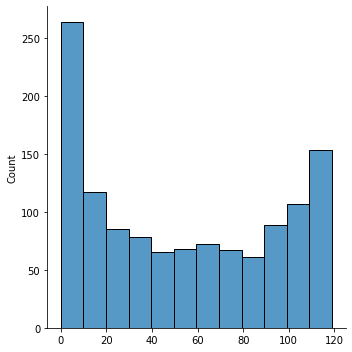

In [ ]:
sns.displot(y_valid);  # 실제 argmax 분포

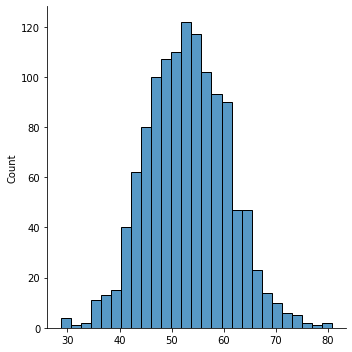

In [ ]:
sns.displot(pred);  # 예상 argmax 분포

평균(55) 중심으로 예측을 한다.

## LGBM
https://nicola-ml.tistory.com/51<br>
https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [ ]:
def LGBM(X_train, y_train, X_valid, y_valid, it):
  train_ds = lgb.Dataset(X_train, label = y_train) 
  valid_ds = lgb.Dataset(X_valid, label = y_valid) 
  params = {'learning_rate': 0.005,   # default is 0.001
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 100,   # default is 31
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          # 'max_cat_group': 10,  # default is 64
          'seed':2021}
  model = lgb.train(params, train_ds, it, valid_ds, verbose_eval=100, early_stopping_rounds=100)
  return model

In [ ]:
model = LGBM(X_train, y_train, X_valid, y_valid, 1000)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1698
[200]	valid_0's l2: 1693.62
[300]	valid_0's l2: 1693.03
Early stopping, best iteration is:
[207]	valid_0's l2: 1692.63


In [ ]:
pred = model.predict(X_valid)

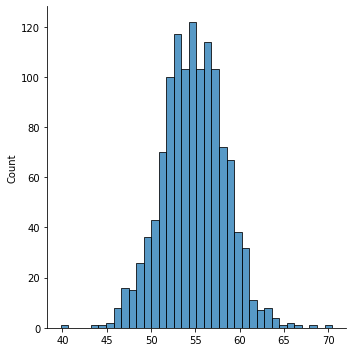

In [ ]:
sns.displot(pred)

이거도 마찬가지로 평균을 중심으로 예측

## pred의 극단값에서 실제 argmax값들은 유의미한 차이를 보일지

In [ ]:
sum(pred > 60)

76

In [ ]:
np.mean(y_valid)

53.76101141924959

In [ ]:
np.mean(y_valid[pred > 60])

62.46052631578947

In [ ]:
np.mean(y_valid[pred < 50])

44.10377358490566

어느정도는 의미가있다

## argmax말고 max

In [ ]:
y_train_max

array([1.00746   , 1.00357962, 1.01142848, ..., 1.00632513, 1.00325048,
       1.00082004])

In [ ]:
model = DNN(X_train, y_train_max, X_valid, y_valid_max)

Epoch 1/16
491/491 [==============================] - 2s 3ms/step - loss: 0.0400 - mse: 0.0400 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 2/16
491/491 [==============================] - 1s 2ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 3/16
491/491 [==============================] - 1s 2ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/16
491/491 [==============================] - 1s 2ms/step - loss: 5.7449e-04 - mse: 5.7449e-04 - val_loss: 3.5496e-04 - val_mse: 3.5496e-04
Epoch 5/16
491/491 [==============================] - 1s 2ms/step - loss: 3.2836e-04 - mse: 3.2836e-04 - val_loss: 2.3712e-04 - val_mse: 2.3712e-04
Epoch 6/16
491/491 [==============================] - 1s 2ms/step - loss: 2.6547e-04 - mse: 2.6547e-04 - val_loss: 2.0349e-04 - val_mse: 2.0349e-04
Epoch 7/16
491/491 [==============================] - 1s 2ms/step - loss: 2.2376e-04 - mse: 2.2376e-04 - val_loss: 2.6522e-04 - val_mse: 2.6522e-04
Epoch 8/16
4

In [ ]:
np.mean((y_valid_max - np.mean(y_valid_max)) ** 2)  # 평균으로 예측했을때 mse

0.00018284616055955742

딥러닝은 별로 -- 데이터의 사이즈가 작아서그런가

In [ ]:
model = LGBM(X_train, y_train_max, X_valid, y_valid_max, 1000)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.000314428
[200]	valid_0's l2: 0.000315202
Early stopping, best iteration is:
[120]	valid_0's l2: 0.000314203


In [ ]:
np.mean((y_valid_max - np.mean(y_valid_max))**2)

0.0003137728929732729

LGBM으로 가자

이건 max의 분포

In [ ]:
pred = model.predict(X_valid)

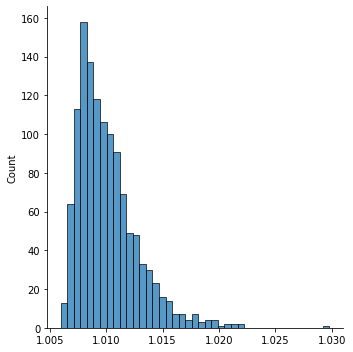

In [ ]:
sns.displot(pred)

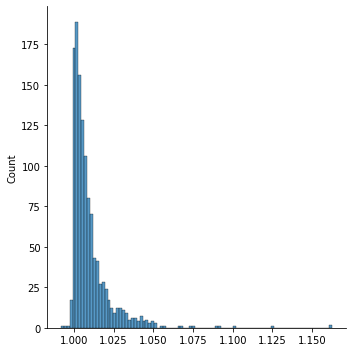

In [ ]:
sns.displot(y_valid_max)

In [ ]:
sum(pred > 1.015)

63

In [ ]:
np.mean(y_valid_max[pred > 1.015])

1.0186749422360981

In [ ]:
np.mean(y_valid_max)

1.0097173004127054

## Test

### train + valid

In [ ]:
X_train_ = X_train.append(X_valid)
y_train_ = np.array(y_train.tolist() + y_valid.tolist())
y_train_max_ = np.array(y_train_max.tolist() + y_valid_max.tolist())

In [ ]:
model_argmax = LGBM(X_train, y_train, X_train, y_train, 207)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1334.84
[200]	valid_0's l2: 1071.46
Did not meet early stopping. Best iteration is:
[207]	valid_0's l2: 1056.69


In [ ]:
model_max = LGBM(X_train, y_train_max, X_train, y_train_max, 260)  # 120

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.000261101
Did not meet early stopping. Best iteration is:
[120]	valid_0's l2: 0.00025462


In [ ]:
pred_argmax = model_argmax.predict(X_test)
pred_max = model_max.predict(X_test)

In [ ]:
pred_max = model_max.predict(X_test)

전처리한 후 train-test split했기 때문에 sample_id를 찾아서 수익 구함

In [ ]:
train_idx, test_idx = train_test_split(list(range(len(X))), test_size=0.2, random_state=2021)

In [ ]:
# 그냥 60분있다 막사기
result = 1
for i in tqdm(range(len(test_idx))):
  idx = test_idx[i]
  result *= train_y[train_y['sample_id'] == idx].iloc[60, 3]

100%|██████████| 1533/1533 [00:02<00:00, 647.49it/s]


In [ ]:
pred_argmax

array([53.00499698, 55.1384548 , 59.95246465, ..., 56.18798248,
       53.00022799, 47.98575134])

In [ ]:
# argmax 위치만 사기
result = 1
for i in tqdm(range(len(test_idx))):
  idx = test_idx[i]
  row = round(pred_argmax[i])
  result *= train_y[train_y['sample_id'] == idx].iloc[row, 3]

100%|██████████| 1533/1533 [00:02<00:00, 640.97it/s]


In [ ]:
pred_max

array([1.01241682, 1.00756641, 1.00901985, ..., 1.00876107, 1.01373198,
       1.0180982 ])

In [ ]:
# pred max 가 1.01보다 큰거만 60분 있다가 사기
result = 1
for i in tqdm(range(len(test_idx))):
  idx = test_idx[i]
  # row = round(pred_argmax[i])
  if pred_max[i] > 1.01:
    result *= train_y[train_y['sample_id'] == idx].iloc[60, 3]

100%|██████████| 1533/1533 [00:00<00:00, 1557.74it/s]


In [ ]:
result

0.970648968073435

In [ ]:
# pred max 가 1.01보다 큰거 argmax에 팔기
result = 1
pred_result = []
for i in tqdm(range(len(test_idx))):
  idx = test_idx[i]
  row = round(pred_argmax[i])
  if pred_max[i] > 1.005:
    pred_result.append(train_y[train_y['sample_id'] == idx].iloc[row, 3])
    result *= train_y[train_y['sample_id'] == idx].iloc[row, 3]

100%|██████████| 1533/1533 [00:04<00:00, 323.96it/s]


In [ ]:
th1 = 1.012
th2 = 

In [ ]:
# pred max 가 1.01보다 큰거 argmax에 팔기
result = 1
temp = []
for i in tqdm(range(len(test_idx))):
  idx = test_idx[i]
  row = round(pred_argmax[i])
  if pred_max[i] > 1.012:
    result *= train_y[train_y['sample_id'] == idx].iloc[row, 3]
  else:
    result += result * (train_y[train_y['sample_id'] == idx].iloc[row, 3] - 1) * max(0, (pred_max[i] - 1.007) / 0.005)

100%|██████████| 1533/1533 [00:02<00:00, 650.47it/s]


In [ ]:
# pred max 가 1.01보다 큰거 argmax에 팔기
result = 1
for i in tqdm(range(len(test_idx))):
  idx = test_idx[i]
  row = 119
  if pred_max[i] > 1.001:
    result *= train_y[train_y['sample_id'] == idx].iloc[row, 3]
  else:
    result += result * (train_y[train_y['sample_id'] == idx].iloc[row, 3] - 1) * max(0, (pred_max[i] - 1) / 0.001)

100%|██████████| 1533/1533 [00:02<00:00, 667.20it/s]


In [ ]:
result

1.1148187612684746

In [ ]:
sum(pred_max > 1.001)

328

In [ ]:
result

1.212811819585292

In [ ]:
np.mean(pred_max)

1.0101439880507261

In [ ]:
result

0.9192633754485189

In [ ]:
len(pred_max)

1533

In [ ]:
sum(pred_max > 1.01)

637

## Submission file 만들기

In [ ]:
y_train

{'argmax': array([ 14,  29, 104, ...,  65,  41,  45]),
 'max': array([1.00133276, 1.0014832 , 1.01278174, ..., 1.01002729, 1.00239241,
        1.01186645])}

In [ ]:
model_argmax = LGBM(X, y['argmax'],X, y['argmax'], 207)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1423.88
[200]	valid_0's l2: 1211.61
Did not meet early stopping. Best iteration is:
[207]	valid_0's l2: 1199.95


In [ ]:
model_max = LGBM(X, y['max'], X, y['max'], 120)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.000265853
Did not meet early stopping. Best iteration is:
[120]	valid_0's l2: 0.000260464


In [ ]:
test_real = pd.read_csv('./open/test_x_df.csv')

In [ ]:
X_pred = preprocess_x(test_real)  # 전처리

100%|██████████| 535/535 [00:01<00:00, 341.87it/s]


In [ ]:
real_argmax = model_argmax.predict(X_pred)
real_max = model_max.predict(X_pred)

In [ ]:
idxes = test_real['sample_id'].unique()

In [ ]:
submission = []

In [ ]:
# pred max 가 1.01보다 큰거 argmax에 팔기
result = 1
temp = []
for i in tqdm(range(len(test_idx))):
  idx = test_idx[i]
  row = round(pred_argmax[i])
  if pred_max[i] > 1.012:
    result *= train_y[train_y['sample_id'] == idx].iloc[row, 3]
  else:
    result += result * (train_y[train_y['sample_id'] == idx].iloc[row, 3] - 1) * max(0, (pred_max[i] - 1.007) / 0.005)

In [ ]:
# 1.012 초과인 대상들에 대해서 argmax에 팔기 전략, 1.007과 1.012 사이의 대상들은 직선형태로 매매 비율을 설정
submission = []
for idx, i in enumerate(idxes):
  if real_max[idx] > 1.012:
    submission.append([i, 1, round(real_argmax[idx])])  
  else:
    submission.append([i, max(0, (real_max[idx] - 1.007) / 0.005), round(real_argmax[idx])])


In [ ]:
submission = pd.DataFrame(submission)
submission.columns = ['sample_id', 'buy_quantity', 'sell_time']
submission.to_csv('submission_argmax.csv', index=False)

In [ ]:
sum(submission['sell_time'] != 0)

379